In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install seaborn

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import torch

cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import numpy as np

totalbars=32 #total bars as input
NUM_PITCHES=4 # all possible notes to play


NOTESPERBAR=16
TOTAL_NOTES=NOTESPERBAR*totalbars

num_features=NUM_PITCHES #size of input feature vector

teacherforcing=False #not used but it will be needed


In [3]:



#Generating dummy data
a= np.random.randint(NUM_PITCHES, size=TOTAL_NOTES)
print(a)
data = np.zeros((TOTAL_NOTES, NUM_PITCHES))
data[np.arange(TOTAL_NOTES), a] = 1 #generating dummy data


#adding 1 dimension, 1x32x4
data = data[np.newaxis, :, :]

data.shape

[1 3 3 1 3 2 0 2 0 2 0 3 0 3 1 2 1 3 0 2 0 0 2 3 1 1 2 0 3 3 1 1 1 2 0 3 2
 2 3 3 0 0 2 2 0 3 1 0 2 1 0 2 1 3 1 0 1 2 2 3 0 3 2 0 0 3 2 0 3 0 1 2 2 2
 1 2 2 3 1 1 0 3 3 3 1 1 0 2 0 1 3 2 3 0 0 3 3 2 1 2 2 3 1 0 2 0 1 0 3 3 1
 0 1 3 0 2 2 3 3 0 2 3 2 1 2 2 0 3 1 2 2 2 1 1 3 1 3 0 3 2 2 1 0 3 2 2 1 1
 0 2 3 3 0 3 0 0 3 3 1 3 2 2 0 1 0 0 0 2 1 2 1 1 0 2 1 0 3 3 0 3 0 3 2 3 2
 1 2 2 1 2 1 2 0 0 2 3 2 3 0 3 2 1 1 1 2 1 0 0 3 3 0 0 2 1 0 3 1 2 0 0 3 3
 1 2 0 2 1 3 3 3 2 2 2 1 2 0 2 0 3 2 2 0 0 2 3 0 3 2 0 2 3 0 0 2 1 3 2 1 1
 3 3 0 0 3 3 3 2 2 1 0 2 2 0 3 2 3 1 0 1 3 2 2 2 3 2 0 3 1 2 0 0 3 2 0 3 1
 3 0 2 3 2 1 3 3 2 1 0 3 0 1 3 1 3 2 0 1 3 0 1 0 0 2 1 2 1 3 2 1 2 2 3 1 0
 1 1 1 1 3 0 2 0 1 0 3 3 0 1 1 2 3 0 0 2 3 3 0 1 1 3 1 2 1 3 1 1 1 1 3 1 3
 2 3 1 2 2 0 2 0 3 3 1 3 1 2 3 1 3 2 1 0 1 1 1 1 1 3 1 1 0 0 3 2 2 2 0 1 2
 3 2 3 3 1 3 3 3 1 3 1 1 0 3 3 3 1 3 0 2 1 0 0 0 1 1 3 0 3 1 3 3 0 0 2 1 2
 1 2 2 2 3 0 1 1 1 0 1 2 1 3 2 2 2 0 1 2 0 1 1 3 2 2 3 1 3 3 2 0 0 1 2 1 3
 1 3 1 3 3 1 2 2 1 0 2 2 

(1, 512, 4)

In [4]:
#half of this is not yet needed but maybe it will be to visualize the latent space
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
from sklearn.decomposition import PCA
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.dark_palette("purple"))

MODEL:

In [5]:
import torch.nn as nn
from torch.nn.functional import softplus

# define size variables
input_size = NUM_PITCHES

enc_hidden_size=2048 #hidden size of encoder
conductor_hidden_size=1024 #hidden size of decoder


decoders_hidden_size=1024 #hidden size of decoder
decoders_initial_size=512 #decoder input size

n_embeddings=16

n_layers_conductor=2
n_layers_decoder=3

latent_features=512 #latent space dimension

sequence_length = 32



class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_features):
        super(VariationalAutoencoder, self).__init__()
        
        self.latent_features = latent_features
       
        
        
        #data goes into bidirectional encoder
        self.encoder = torch.nn.LSTM(
                batch_first = True,
                input_size = input_size,
                hidden_size = enc_hidden_size,
                num_layers = 1,
                bidirectional = True)
        
        #encoded data goes onto connect linear layer. inputs must be*2 because LSTM is bidirectional
        #output must be 2*latentspace because it needs to be split into miu and sigma right after.
        self.encoderOut = nn.Linear(in_features=enc_hidden_size*2, out_features=latent_features*2)
        
        
        #self.decoderIn = nn.Linear(in_features=latent_features, out_features=conductor_initial_size)
        
        # The latent code must be decoded into the original image
#         self.conductor = torch.nn.LSTM(
#                 batch_first=True,
#                 input_size=self.latent_features,
#                 hidden_size=conductor_hidden_size,
#                 num_layers=2,
#                 bidirectional = False)
                
        #Linear layer after leaving condunctor
#         self.conductorout = nn.Linear(in_features=TOTAL_NOTES, out_features=2*n_embeddings)    
        
        
        # The latent code must be decoded into the original structure
#         self.decoders = [torch.nn.LSTM(
#                 batch_first=True,
#                 input_size=decoders_initial_size,
#                 hidden_size=decoders_hidden_size,
#                 num_layers=2,
#                 bidirectional = False)] * n_embeddings

        # Define the conductor and note decoder
        self.conductor = nn.LSTM(decoders_initial_size, decoders_initial_size, num_layers=1)
        self.decoder = nn.LSTM(2*decoders_initial_size, decoders_initial_size, num_layers=1)

        
    #used to initialize the hidden layer of the encoder to zero before every batch
    def init_hidden(self, batch_size):
        #must be 2 x batch x hidden_size because its a bi-directional LSTM
        init = torch.zeros(2, batch_size, enc_hidden_size, device=device)
        c0 = torch.zeros(2, batch_size, enc_hidden_size, device=device)
    
        #2 because has 2 layers
        init_conductor = torch.zeros(n_layers_conductor, batch_size, conductor_hidden_size, device=device)
        c_condunctor = torch.zeros(n_layers_conductor, batch_size, conductor_hidden_size, device=device)
    
        #2 because has 2 layers
        init_decoders = torch.zeros(n_layers_decoder, batch_size, decoders_hidden_size, device=device)
        c_decoders= torch.zeros(n_layers_decoder, batch_size, decoders_hidden_size, device=device)
        
        
        return init,c0,init_conductor,c_condunctor,init_decoders,c_decoders


    def forward(self, x): 
        outputs = {}
        
        batch_size = x.size(0)
        
        print("Input size",x.size())
        
        #creates hidden layer values
        h0,c0,hconductor,cconductor,hdecoders,cdecoders = self.init_hidden(batch_size)
        
        #resets encoder at the beginning of every batch and gives it x
        x, hidden = self.encoder(x, ( h0,c0))
          
        print("after enconder",x.shape)
        
        #goes from 4096 to 1024
        x = self.encoderOut(x)
        
        print("after encoder linear",x.shape)
        
        
        
        # Split encoder outputs into a mean and variance vector 
        mu, log_var = torch.chunk(x, 2, dim=-1)
                
        # Make sure that the log variance is positive
        log_var = softplus(log_var)
               
        # :- Reparametrisation trick
        # a sample from N(mu, sigma) is mu + sigma * epsilon
        # where epsilon ~ N(0, 1)
                
        # Don't propagate gradients through randomness
        with torch.no_grad():
            batch_size = mu.size(0)
            epsilon = torch.randn(batch_size, 1, self.latent_features)
            
            if cuda:
                epsilon = epsilon.cuda()
        
        #setting sigma
        sigma = torch.exp(log_var*2)
        
        
        #generate z - latent space
        z = mu + epsilon * sigma
        linear_z = nn.Linear(in_features=latent_features, out_features=32)
        z = z.permute(0,2,1)
        print('z after permutation', z.shape)
        z = linear_z(z)
        print('z after linear', z.shape)
        z = z.permute(2,0,1)
        print('z after 2nd permutation', z.shape)
        
        print("z space generated",z.shape)
        
        
        # Define the conductor and note decoder
#         conductor = nn.LSTM(decoders_initial_size, decoders_initial_size)
#         decoder = nn.LSTM(2*decoders_initial_size, decoders_initial_size)

        # Linear note to note type (classes/pitches)
        linear = nn.Linear(decoders_initial_size, NUM_PITCHES)

        conductor_hidden = (torch.randn(1, batch_size, decoders_initial_size), torch.randn(1, batch_size, decoders_initial_size))
        notes = []

        # For the first timestep the note is the embedding
        note = torch.zeros(batch_size, batch_size, decoders_initial_size)

        # Go through each element in the latent sequence
        for i in range(sequence_length):

            # Generate an embedding vector
            
            embedding, conductor_hidden = self.conductor(z[i].view(1, 1, -1), conductor_hidden)    

            # Reset the decoder state of each 16 bar sequence
            decoder_hidden = (torch.randn(1, batch_size, decoders_initial_size), torch.randn(1, batch_size, decoders_initial_size))

            for _ in range(16):
                # Concat embedding with previous note
                e = torch.cat([embedding, note], dim=-1)

                # Generate a single note
                note, decoder_hidden = self.decoder(e.view(1, 1, -1), decoder_hidden)

                # The note vector must be a probability of the different note types, e.g. (C#, F, E)
                notes.append(torch.softmax(linear(note.view(batch_size, -1)), dim=1))

        notes = torch.cat(notes)

        print('notes:', notes.shape)

        
        outputs["x_hat"] = notes.unsqueeze(0)
        outputs["z"] = z
        outputs["mu"] = mu
        outputs["log_var"] = log_var
        
        return outputs




net = VariationalAutoencoder(latent_features)

# Transfer model to GPU if available
if cuda:
    net = net.cuda()

print(net)

VariationalAutoencoder(
  (encoder): LSTM(4, 2048, batch_first=True, bidirectional=True)
  (encoderOut): Linear(in_features=4096, out_features=1024, bias=True)
  (conductor): LSTM(512, 512)
  (decoder): LSTM(1024, 512)
)


Optimizer

In [6]:
#directly taken from notebook, probably some adaptation might be needed

from torch.nn.functional import binary_cross_entropy
from torch import optim



def ELBO_loss(y, t, mu, log_var):
    # Reconstruction error, log[p(x|z)]
    # Sum over features
    likelihood = -binary_cross_entropy(y, t, reduction="none")
    likelihood = likelihood.view(likelihood.size(0), -1).sum(1)

    # Regularization error: 
    # Kulback-Leibler divergence between approximate posterior, q(z|x)
    # and prior p(z) = N(z | mu, sigma*I).
    
    # In the case of the KL-divergence between diagonal covariance Gaussian and 
    # a standard Gaussian, an analytic solution exists. Using this excerts a lower
    # variance estimator of KL(q||p)
    kl = -0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=1)

    # Combining the two terms in the evidence lower bound objective (ELBO) 
    # mean over batch
    ELBO = torch.mean(likelihood) - torch.mean(kl)
    
    # notice minus sign as we want to maximise ELBO
    return -ELBO, kl.sum()



# define our optimizer
# The Adam optimizer works really well with VAEs.
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = ELBO_loss

Testing if forward pass works

In [7]:
from torch.autograd import Variable

#setting dummy data
x = data



#setting input ans tensor variable
x = Variable(torch.Tensor(x))

if cuda:
    x = x.cuda()
    
    

#running forward pass
outputs = net(x)


#AFTER THIS NOTHING IS DONE YET ------
x_hat = outputs["x_hat"]
mu, log_var = outputs["mu"], outputs["log_var"]
z = outputs["z"]

loss, kl = loss_function(x_hat, x, mu, log_var)

print(x.shape)
print(x_hat.shape)
print(z.shape)
print(loss)
print(kl)

Input size torch.Size([1, 512, 4])
after enconder torch.Size([1, 512, 4096])
after encoder linear torch.Size([1, 512, 1024])
z after permutation torch.Size([1, 512, 512])
z after linear torch.Size([1, 512, 32])
z after 2nd permutation torch.Size([32, 1, 512])
z space generated torch.Size([32, 1, 512])
notes: torch.Size([512, 4])
torch.Size([1, 512, 4])
torch.Size([1, 512, 4])
torch.Size([32, 1, 512])
tensor(1232.2911, grad_fn=<NegBackward>)
tensor(40265.0625, grad_fn=<SumBackward0>)


Plot network output:

0.27745962


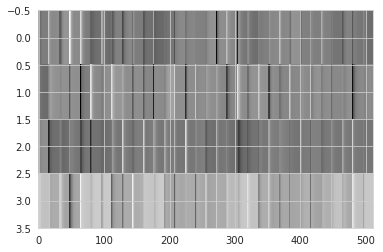

In [8]:
x_np = x_hat.detach().numpy()
x_np = x_np.squeeze(0)
# x_np.shape
print(x_np[0][0])
plt.imshow(x_np.T, aspect='auto', cmap='Greys',  interpolation='nearest')

Plot original data:

0.0


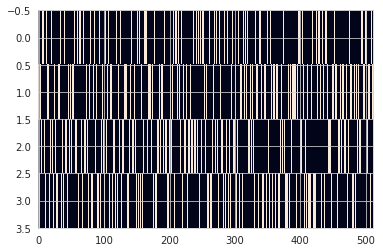

In [9]:
data_to_display = data.squeeze(0)
# data_to_display.shape
print(data_to_display[0][0])
plt.imshow(data_to_display.T, aspect='auto')

## TRAINING

In [ ]:
import os

num_epochs = 100
tmp_img = "tmp_vae_out.png"
show_sampling_points = False

train_loss, valid_loss = [], []
train_kl, valid_kl = [], []

device = torch.device("cuda:0" if cuda else "cpu")
print("Using device:", device)

for epoch in range(num_epochs):
    batch_loss, batch_kl = [], []
    net.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for x, m in train_loader:
        x = Variable(x)
        
        # This is an alternative way of putting
        # a tensor on the GPU
        x = x.to(device)
        
        outputs = net(x)
        x_hat = outputs['x_hat']
        mu, log_var = outputs['mu'], outputs['log_var']

        elbo, kl = loss_function(x_hat, x, mu, log_var)
        
        optimizer.zero_grad()
        elbo.backward()
        optimizer.step()
        
        batch_loss.append(elbo.item())
        batch_kl.append(kl.item())

    train_loss.append(np.mean(batch_loss))
    train_kl.append(np.mean(batch_kl))

    # Evaluate, do not propagate gradients
    with torch.no_grad():
        net.eval()
        
        # Just load a single batch from the test loader
        x, y = next(iter(test_loader))
        x = Variable(x)
        
        x = x.to(device)
        
        outputs = net(x)
        x_hat = outputs['x_hat']
        mu, log_var = outputs['mu'], outputs['log_var']
        z = outputs["z"]

        elbo, kl = loss_function(x_hat, x, mu, log_var)
        
        # We save the latent variable and reconstruction for later use
        # we will need them on the CPU to plot
        x = x.to("cpu")
        x_hat = x_hat.to("cpu")
        z = z.detach().to("cpu").numpy()

        valid_loss.append(elbo.item())
        valid_kl.append(kl.item())